# Heart Disease Example
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

This example uses a labeled heart disease dataset retrieved from the UCI Machine Learning Repository.

* [processed.cleveland.data](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data): Labeled patient data (303 patients = 303 records)

### A little help from our friends...

* [matplotlib](https://matplotlib.org/) 
* [NumPy](https://numpy.org/)
* [pandas](https://pandas.pydata.org/) 
* [scikit-learn](https://scikit-learn.org/)

Installation:
```
conda install matplotlib
conda install numpy
conda install pandas
conda install scikit-learn
```

In [1]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from subprocess import call

### Data wrangling

Load the data into a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) `heart` using [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).

In [2]:
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
dtype = ['int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'float64', 'int32', 'Int32', 'Int32', 'int32']
dtype = dict(zip(names, dtype))

heart = pd.read_csv('data/processed.cleveland.data', names=names, dtype=dtype, na_values='?')
heart.dropna(inplace=True)
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,4,140,241,0,0,123,1,0.2,2,0,7,1
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7,3


Extract the labels into a [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) `y`

In [3]:
y = (heart.num > 0).rename('y')
y

0      False
1       True
2       True
3      False
4      False
       ...  
297     True
298     True
299     True
300     True
301     True
Name: y, Length: 297, dtype: bool

Extract the features into a DataFrame `x` and perform one hot encoding of categorical variables using [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).

In [4]:
x = pd.concat([
    heart.drop(['num', 'cp', 'slope', 'thal'], axis=1),
    pd.get_dummies(heart.cp, prefix='cp'),
    pd.get_dummies(heart.slope, prefix='slope'),
    pd.get_dummies(heart.thal, prefix='thal')
], axis=1)
x

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,cp_1,cp_2,cp_3,cp_4,slope_1,slope_2,slope_3,thal_3,thal_6,thal_7
0,63,1,145,233,1,2,150,0,2.3,0,1,0,0,0,0,0,1,0,1,0
1,67,1,160,286,0,2,108,1,1.5,3,0,0,0,1,0,1,0,1,0,0
2,67,1,120,229,0,2,129,1,2.6,2,0,0,0,1,0,1,0,0,0,1
3,37,1,130,250,0,0,187,0,3.5,0,0,0,1,0,0,0,1,1,0,0
4,41,0,130,204,0,2,172,0,1.4,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,140,241,0,0,123,1,0.2,0,0,0,0,1,0,1,0,0,0,1
298,45,1,110,264,0,0,132,0,1.2,0,1,0,0,0,0,1,0,0,0,1
299,68,1,144,193,1,0,141,0,3.4,2,0,0,0,1,0,1,0,0,0,1
300,57,1,130,131,0,0,115,1,1.2,1,0,0,0,1,0,1,0,0,0,1


Split the features and labels into a training set `x_train` `y_train` and test set `x_test` `y_test` using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

### Model training

Initialize a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `rf` and train it using the training features `x_train` and labels `y_train`.

In [6]:
rf = RandomForestClassifier(n_estimators=500, random_state=123)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

Visualize tree `t` from random forest `rf` using [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html).

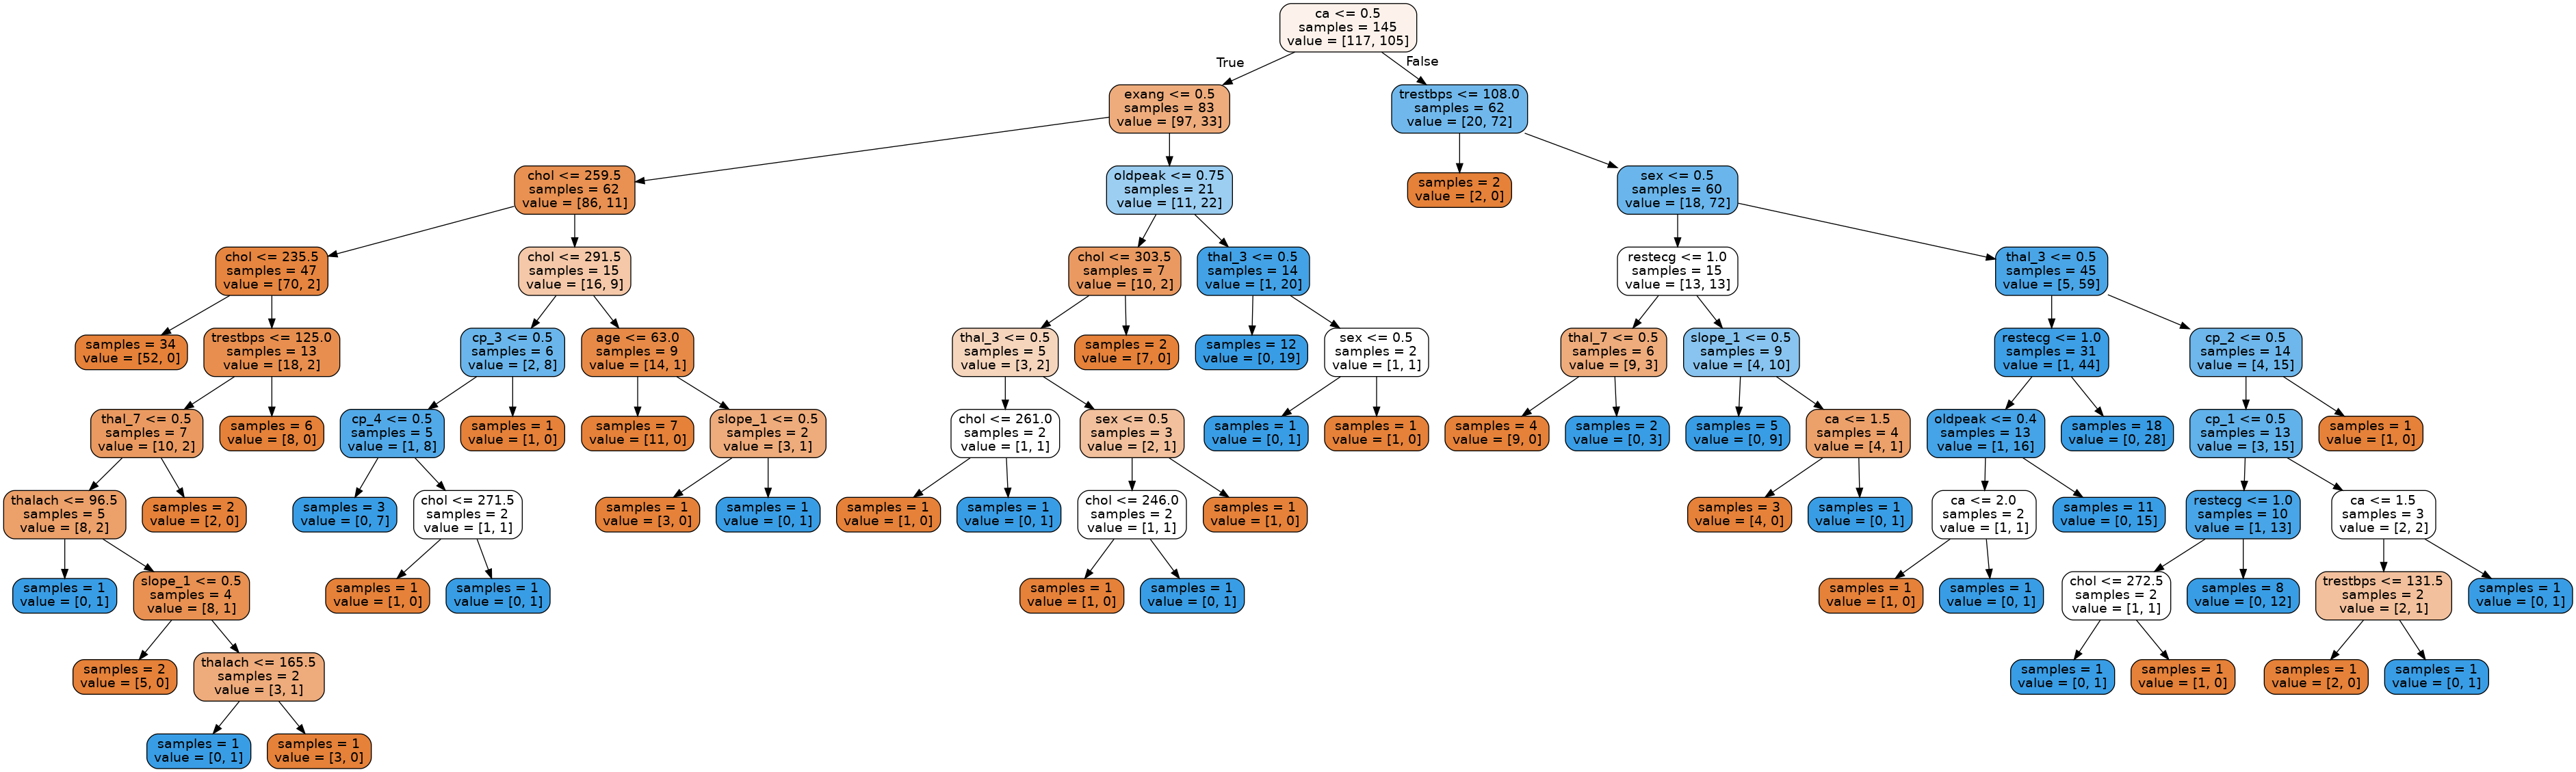

In [7]:
t = 0
export_graphviz(rf.estimators_[t], out_file='/tmp/rf.dot', feature_names=x_train.columns, rounded = True, impurity = False, filled = True)
call('dot -Tpng /tmp/rf.dot -o /tmp/rf.png -Gdbi=600', shell=True)
display.Image(filename = '/tmp/rf.png')

### Model evaluation

Make probability predictions `y_prob` using the trained model `rf`, test features `x_test`, and [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba).

In [8]:
y_prob = rf.predict_proba(x_test)[:,1]
y_prob

array([0.232, 0.966, 0.748, 0.318, 0.512, 0.68 , 0.364, 0.084, 0.176,
       0.224, 0.236, 0.842, 0.55 , 0.082, 0.908, 0.64 , 0.916, 0.208,
       0.202, 0.174, 0.462, 0.86 , 0.01 , 0.564, 0.74 , 0.786, 0.614,
       0.022, 0.768, 0.968, 0.674, 0.688, 0.158, 0.544, 0.258, 0.594,
       0.342, 0.072, 0.614, 0.916, 0.316, 0.238, 0.02 , 0.302, 0.916,
       0.164, 0.942, 0.246, 0.204, 0.646, 0.344, 0.572, 0.346, 0.444,
       0.888, 0.646, 0.996, 0.928, 0.254, 0.03 , 0.018, 0.688, 0.976,
       0.78 , 0.946, 0.174, 0.816, 0.912, 0.432, 0.288, 0.896, 0.968,
       0.14 , 0.066, 0.754])

Display [confusion matricies](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) at various thresholds using the test labels `y_test`, probability predictions `y_prob, and [matplotlib](https://matplotlib.org/3.1.1/gallery/index.html).

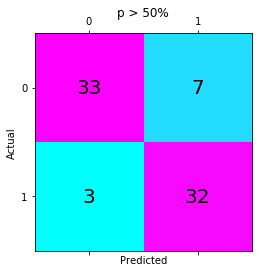

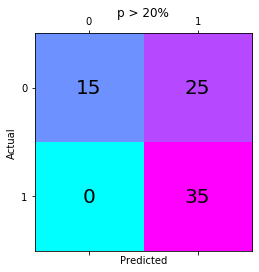

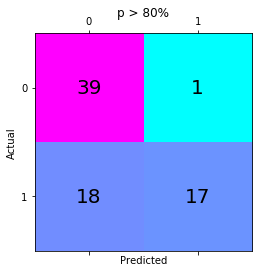

In [9]:
for threshold in [0.5, 0.2, 0.8]:
    cm = confusion_matrix(y_test, y_prob > threshold)
    fig, ax = plt.subplots()
    ax.matshow(cm, cmap='cool')
    ax.set(title='p > {:.0%}'.format(threshold), xlabel='Predicted', ylabel='Actual')
    for (i, j), n in np.ndenumerate(cm):
        ax.text(j, i, n, ha='center', va='center', fontsize=20)
    plt.show()

Calculate the AUC and plot a ROC curve using the test labels `y_test`, probability predictions `y_prob`, [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html), [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), and [matplotlib](https://matplotlib.org/3.1.1/gallery/index.html).

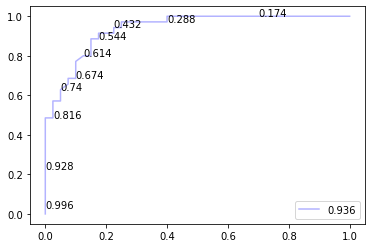

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
fig, ax = plt.subplots()
plt.plot(fpr, tpr, label='{:.3f}'.format(auc), color=[.7,.7,1])
plt.legend(loc=4)
for i in range(1, len(fpr), 3):
    ax.annotate(thresholds[i], (fpr[i], tpr[i]))
plt.show()

##### Attribution
UCI Machine Learning Repository
* https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Authors
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.